# Removing Background Using a Neural Network

The training dataset for the Humpback Whale Identification on Kaggle has 25,361 images.  These images are of variable size, quality and background.  


## The Problem
Cropping this many images by hand is problematic, because it is incredibly time consuming.  For completness, I attempted to remove the background on one image using the free open source image editor Gimp.  This took approxamately 5 minutes.  So it can be estimated that if one was to crop the background out of the entire training dataset it would take 126,805 minutes or roughly 88 days, provided you don't sleep, eat, or otherwise do anything but crop images.  

## Proposed Solution
Can a neural net be used to automate the work of cropping out the background on images of various size and quality?  The answer to the question is that it depends.  There are two ways to accomplish this task.

   * Train your model to recognize what is background and remove that.
   * Train your model to recognize what is a whale's tail and remove everything else.

In order to accomplish either of these tasks, the neural net needs to be able to identify what is background and what is an object.  Convolutional neural networks have been used to train object recognition models in the past.  These models can identify object types in images with many objects.  More importantly, these CNN's have been used to perform image manipulations such as drawing bounding boxes, creating a mask over the object, and labeling certain images with the object type. But these neural networks have been trained on datasets with 50,000+ images.  Which means that some number of people have gone through these large datasets and labeled these images.  Eventhough the Humpback Whale Identification dataset is only 25,000+ images, it is still too many 

So the revised question should be, can a much small number of training images be used to train a neural net model to remove the image background?  

## Software Used

The main Python modules needed for this are
   * OpenCV: A library for reading and manipulating images.
   * Numpy: For handling mulit-dimensional arrays that OpenCV will create and maniplulate.
   * Keras: A high level API for creating neural networks.
   * Tensorflow: A high level API used by Keras for creating neural networks.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Input, MaxPool2D, UpSampling2D, Concatenate, Conv2DTranspose
import tensorflow as tf
from keras.optimizers import Adam
from keras import backend as K
from scipy.misc import imresize
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
import os
import cv2
from random import randint
import random
from keras.preprocessing.image import array_to_img, img_to_array, load_img, ImageDataGenerator
import skimage
import copy
%matplotlib inline


Using TensorFlow backend.


## Creating a Smaller Training Set

Even with a small training dataset size of 349 images, this is still a time consumming process to try to remove the background by hand.  This is where software like OpenCV can help.

### Image Thresholding in OpenCV

With image thresholding, the user will transform the image based on a set of criteria that are specified to the threshold function.  As an example, take the original black and white image below.

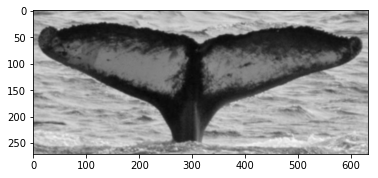

In [2]:
orig_dir = "/home/james/Kaggle/Whale/Data/train/1/"
img = cv2.imread(orig_dir + "/" + "8201ded69.jpg",0)
plt.imshow(img, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye can easily tell where the tail is, and where the background is.  One could probably describe in detail what the background looks like, but that won't do a computer much good.  Even though the tail shows up in great detail.  The waves and surf also show up in great detail.  Which can make for a messy display.

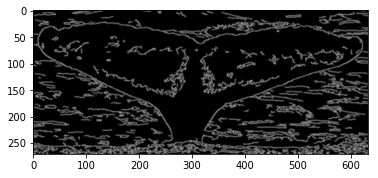

In [3]:
edges = cv2.Canny(img,100,200)
plt.imshow(edges, cmap = 'gray', interpolation = 'bicubic')
plt.show()

The human eye might be able to take a marker and draw the outline of the tail, but that description of what a tail and background, doesn't hold true anymore.  The main point in using the Canny function is to show that there are many more details in an image that may be imperceptible to the human eye, but are readily available to a computer when they are reading an image as an array of pixels. 

A technique that can be useful for sharpening lines is to run a filter over the image.  This can be done by using the filter2D function in OpenCV.  This will help later when we want to indentify the features of the tail.

In [4]:
# Sharpen Image
kernel = np.zeros( (9,9), np.float32)
kernel[4,4] = 2.0   #Identity, times two! 

#Create a box filter:
boxFilter = np.ones( (9,9), np.float32) / 81.0

#Subtract the two:
kernel = kernel - boxFilter

#Run the filter
sharpen = cv2.filter2D(img, -1, kernel)

Now a good way of cutting down unimportant features is to using a thresholding algormithm to reduce some of the background noise.  The threshold function in OpenCV will basicaly transform every pixel that meets the thresholding criteria, to a value which will be specied.  Therefore in the function call below, the threshold is set to 50, and the maximum value that will be used to replace the pixel if it falls below or above the threshold.  The last argument, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, is the type of threshold to use.  There are 6 different types of thresholding. I found that the adaptive threshold with a Gaussian window worked the best on large groups of images that vary in quality.  Therefore below, you can see what the threshold looks like

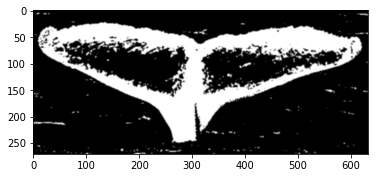

In [5]:
ret,thresh = cv2.threshold(sharpen,70,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C)
plt.imshow(thresh, cmap = 'gray', interpolation = 'bicubic')
plt.show()

Now a computer should be able to outline the whale tail.  This can be done with OpenCV and it's findContours function.  This function will take the threshold value above and try to find the contours of the image.

In [6]:
_,contours,hierarchy = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

So now we have a list of contours that the findContours function was able to find.  So now all that has to be done is to find the biggest contour.

In [7]:
contour_shape = {}
i = 0
for contour in contours:
    if contour.shape[0] > 500:
        contour_shape[contour.shape[0]] = i
    i += 1

contour_shape_keys = sorted(contour_shape)
try:
    c = contours[contour_shape[contour_shape_keys[-1]]]
except:
    print("Can't do:", file)

Then all that has to be done is to fill in this contour with black pixels and everything that is not a black pixel, convert them to white pixels.  This will yield a mask that has the tail pixels in black and the background in white.

In [8]:
mask = copy.deepcopy(img)
cv2.drawContours(mask,[c],-1,(0,0,0),-1)
mask[mask != 0] = 255

So why is it important to create a mask?  Image masking allows us to essentially create an array where the shape of the tail is represented in black pixels (0,0,0) and white pixels are represented as (255,255,255).  Every other color falls between those two values.  When you have a numpy array containing 300 by 500 pixels, you can subtract the mask from the original image and this will essentially remove all of the background.  For example if you have a background pixel that is red (255,0,0), and you subract it from the mask, which has put the background at (255,255,255), you get a pixel that is (0,-255,-255), which essential converted to (0,0,0). Therefore every pixel in the background gets converted to a black pixel.  This can be done easily enough with OpenCV's subtract function.

In [9]:
masked_image = cv2.subtract(img,mask)

| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/8201ded69-orig.jpg)|![](images/8201ded69-mask.jpg)|![](images/8201ded69-masked_image.jpg)|

In [10]:
edges2 = cv2.Canny(masked_image,100,200)

If we examine the canniness of the new image compared to the canniness of the the old image shows just how many features were removed.  Features that had nothing to do with the tail.

| Original Canny  | Canny After Masked Image |
| ---- | ---- |
|![](images/8201ded69-edges1.jpg)|![](images/8201ded69-edges2.jpg)|

This looks pretty great right?  So why don't we do this for all the images and just forget about the Neural Network in general?  This is because the thresholding algorithm can't take into account the overall brightness of the image.  It can't take into account when the tail is white already or black.  The next image illustrates this example.

| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/9074c1b18-orig.jpg)|![](images/9074c1b18-mask.jpg)|![](images/9074c1b18-masked_image.jpg)|

So using thresholding and finding countours methods from OpenCV can't get all the masks, mostly because the images quality ranges from terrible to very clear.  However, this method will correctly get 10% of the masks.  You can run the above thresholding algorithm on all 25000+ images and then flip through them manually and select the ones that worked properly.  This is not an exact science, but it is much better then using Gimp to do them by hand.

## Using a Neural Network to Predict Image Masks

After using thresholding and filling countours using OpenCV, there where 349 masks that were created sucessfully.  This is a very small training data set for working with a CNN, therefore a regular CNN won't be an option. 

U-Nets have several advantages over regular convolutional neural netowrks.  First, the U-net works well with relatively few images.  Second, they have the ability to use the softmax activation function in the output layer to predict a pixel wise represention for the target label.So in a U-net model, like a regular CNN, the original image are used as the input features.  In contrast to a regular CNN, the target labels for a U-Net are the 349 image masks that were created above [2].


Building a U-net involves two specific sets of convolutional layers:
   1. Building what looks like a normal convolutional neural network using a series of constricting layers  with maxpooling functions.  The iput layer conforms to the input size of the data, like most neural networks.  Each subsequent layer is downsampled, and maxpooling operations are applied. 
   2. The last half of the U-net is a set of convolutional layers that are upsampled.  This allows for higher resolution  and propagation of context information to the subsequent layers.



### Reading the Images into Memory

Now that you have as small training data set, place the masks into a directory, and the original images into another directory.  Then get the names of all the images into a list so they can be accessed when all of the images are looped over.

In [11]:
# set the necessary directories
data_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_real/"
mask_dir = "/home/james/Kaggle/Whale/Data/train/masks/2/masks_train/"

train_images = os.listdir(data_dir)
train_length = len(train_images)

Neural networks need a standardized input and the above images are of various sizes.  So a definition of a standard height and width will be needed so that the images can be resized.

In [12]:
height=256
width=256

When dealing with images, it is a good idea to create a function that can augment your existing data set.  This accomplishes two things.  First, it helps increase the overall size of your dataset, so that your network has a chance to learn over more data.  Secondly, it helps reduce overfitting by creating images that are slightly different than the originals.

In [13]:
def image_augment(image,mask):
    
    random_int = randint(0,4)
    
    if random_int == 0:
        # We only want to do a small amount of these.
        # Try to randomly flip both image and mask.
        intflip =  randint(0,5)
        if intflip == 0:
            image = cv2.flip(image, 0)
            mask = cv2.flip(mask,0)
        elif intflip == 1:
            image = cv2.flip(image, 1)
            mask = cv2.flip(mask,1)
        # Else don't do anything
    
    if random_int == 0 or random_int == 1 or random_int == 2:
        # Introduce some noise
        sigma = randint(0, 50)
        temp_image = np.float64(np.copy(image))
        h = temp_image.shape[0]
        w = temp_image.shape[1]
        noise = np.random.randn(h, w) * sigma

        noisy_image = np.zeros(temp_image.shape, np.float64)
        if len(temp_image.shape) == 2:
            noisy_image = temp_image + noise
        else:
            noisy_image[:,:,0] = temp_image[:,:,0] + noise
            noisy_image[:,:,1] = temp_image[:,:,1] + noise
            noisy_image[:,:,2] = temp_image[:,:,2] + noise  
        
        image = noisy_image
    
    # Scale In
    if random_int == 2 or random_int == 3:
        scale = random.uniform(0.1, 0.9)
        #print(image.shape)
        height,width,channel = image.shape
        scale_out = skimage.transform.rescale(image, scale=scale, mode='constant')
        resized_image = cv2.resize(scale_out, (width, height))
        
        scale_out = skimage.transform.rescale(mask, scale=scale, mode='constant')
        resized_mask = cv2.resize(scale_out, (width, height))
        
        image = resized_image
        mask = resized_mask
    
    # Scale Out
    if random_int == 0 or random_int == 1:
        scale = random.uniform(1.1, 2.2)
        
        #print(image.shape)
        height,width,channel = image.shape
        scale_out = skimage.transform.rescale(image, scale=scale, mode='constant')
        resized_image = cv2.resize(scale_out, (width, height))
        
        scale_out = skimage.transform.rescale(mask, scale=scale, mode='constant')
        resized_mask = cv2.resize(scale_out, (width, height))
        
        image = resized_image
        mask = resized_mask
    
    
    return image,mask

Once the images are identifed, they need to be read into memory, so they can be fed into the fitting function.  The below function should suffice.

In [14]:
def read_image(img_dir,msk_dir,image,mask,dims):
    
    original_img = load_img(img_dir + image)
    resized_img = imresize(original_img, dims+[3])
    array_img = img_to_array(resized_img)/255
    
    original_mask = load_img(msk_dir + image)
    resized_mask = imresize(original_mask, dims+[3])
    array_mask = img_to_array(resized_mask)/255    
    
    array_img,array_mask = image_augment(array_img,array_mask)
    
    return array_img,array_mask

When dealing with images, it is a good idea to create a function to read the data in.  The below function will be executed by Keras during each step when the model is fit.

In [15]:
def image_reader(data_dir, mask_dir, images, batch_size, dims):

        while True:
            ix = np.random.choice(np.arange(len(images)), batch_size)
            imgs = []
            labels = []
            for i in ix:
                # images
                array_img,array_mask = read_image(data_dir,mask_dir,images[i],images[i].split(".")[0] + '.jpg',dims)
                imgs.append(array_img)
                labels.append(array_mask[:, :, 0])
                
            imgs = np.array(imgs)
            labels = np.array(labels)
            
            # return both the images and the masks to the main program 
            yield imgs, labels.reshape(-1, dims[0], dims[1], 1)

The code found below was taken from another Kaggle submission and can be found <a href="https://www.kaggle.com/ecobill/u-nets-with-keras">here</a>.  The basic premise is that two different types of layers are instantiated, and two functions can be made to decrease code reuse.

In [16]:
def down(input_layer, filters, pool=True):
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(input_layer)
    residual = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    if pool:
        max_pool = MaxPool2D()(residual)
        return max_pool, residual
    else:
        return residual

def up(input_layer, residual, filters):
    filters=int(filters)
    upsample = UpSampling2D()(input_layer)
    upconv = Conv2D(filters, kernel_size=(2, 2), padding="same")(upsample)
    concat = Concatenate(axis=3)([residual, upconv])
    conv1 = Conv2D(filters, (3, 3), padding='same', activation='relu')(concat)
    conv2 = Conv2D(filters, (3, 3), padding='same', activation='relu')(conv1)
    return conv2

#### The Input Layer

In [17]:
filters = 64
input_layer = Input(shape = [height, width, 3])
layers = [input_layer]
residuals = []

#### The downsampling path

In [18]:
d1, res1 = down(input_layer, filters)
residuals.append(res1)

filters *= 2

d2, res2 = down(d1, filters)
residuals.append(res2)

filters *= 2

d3, res3 = down(d2, filters)
residuals.append(res3)

filters *= 2

d4, res4 = down(d3, filters)
residuals.append(res4)

filters *= 2

d5 = down(d4, filters, pool=False)

#### The Upsampling Path

In [19]:
up1 = up(d5, residual=residuals[-1], filters=filters/2)

filters /= 2

up2 = up(up1, residual=residuals[-2], filters=filters/2)

filters /= 2

up3 = up(up2, residual=residuals[-3], filters=filters/2)

filters /= 2

up4 = up(up3, residual=residuals[-4], filters=filters/2)

####  The Output Layer

In [20]:
out = Conv2D(filters=1, kernel_size=(1, 1), activation="sigmoid")(up4)

model = Model(input_layer, out)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 64) 36928       conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 64) 0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

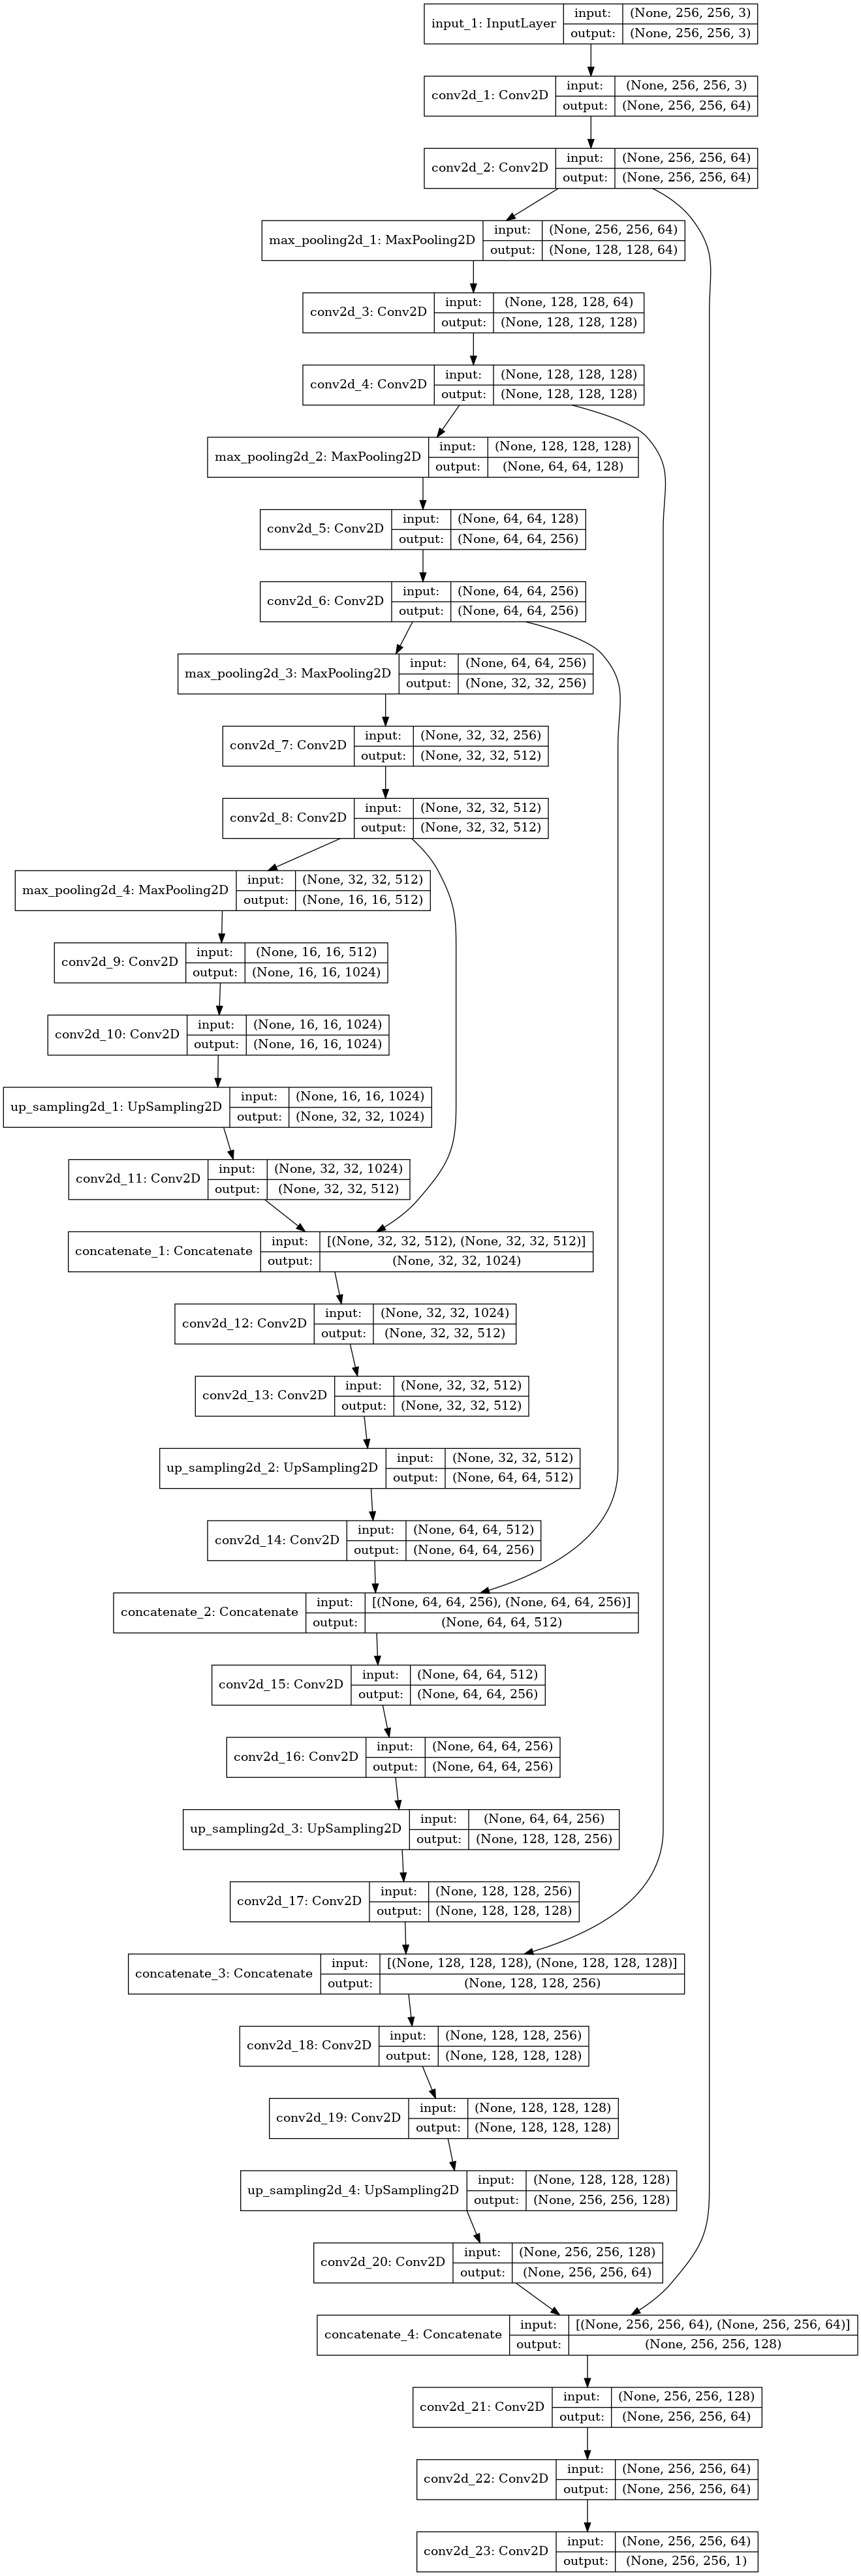

In [21]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
from IPython.display import Image
Image(retina=True, filename='model.png')

Dice coefficient is often used in image segmentation to predict masks for images [3].  It can be written using the GPU optizations in the Keras backend, in this case Tensorflow.  Keras provides api calls to the backends for the round() and reshape() functions in Tensorflow.  However, it has not yet implemented the reduce_sum() function, so we must drop down to using Tensor flow directly. 

In [22]:
def dice_coef(y_true, y_pred):
    smooth = 1e-5
    
    y_true = K.round(K.reshape(y_true, [-1]))
    y_pred = K.round(K.reshape(y_pred, [-1]))
    
    isct = tf.reduce_sum(y_true * y_pred)
    
    return 2 * isct / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred))

It is best practice to use the Keras check pointing ability so that the best model can be saved to a file and loaded later on.  Also if the training gets interupted it can be restarted without loosing the already completed epochs.

In [23]:
filepath="/home/james/Kaggle/Whale/Data/train/whales-masks" + ".best.hdf5"

checkpoint = ModelCheckpoint(filepath, 
                             monitor="dice_coef",
                             verbose=0, 
                             save_best_only=True, 
                             mode='max')


callbacks_list = [checkpoint]

Now compile the model with Adam as the optimizer, and using the dice_coef function written above as the metric.

In [24]:
model.compile(optimizer=Adam(1e-4), loss='binary_crossentropy', metrics=[dice_coef])

And instantiate the the image reader function as an object so it can be called by the fit_generator() function in Keras.

In [25]:
train_gen = image_reader(data_dir, mask_dir, train_images, 5,[height, width])

All that is left to do is just train the model and record the statistics in a variable called history which will allow us to graph the loss and dice coeficient results at each epoch.

In [26]:
history = model.fit_generator(train_gen, 
                    steps_per_epoch=100, 
                    epochs=600,
                    callbacks=callbacks_list,
                    verbose=0
                   )

/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  after removing the cwd from sys.path.
/usr/local/Anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: `imresize` is deprecated!
`imresize` is deprecated in SciPy 1.0.0, and will be removed in 1.3.0.
Use Pillow instead: ``numpy.array(Image.fromarray(arr).resize())``.
  
/home/james/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/home/james/.local/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing

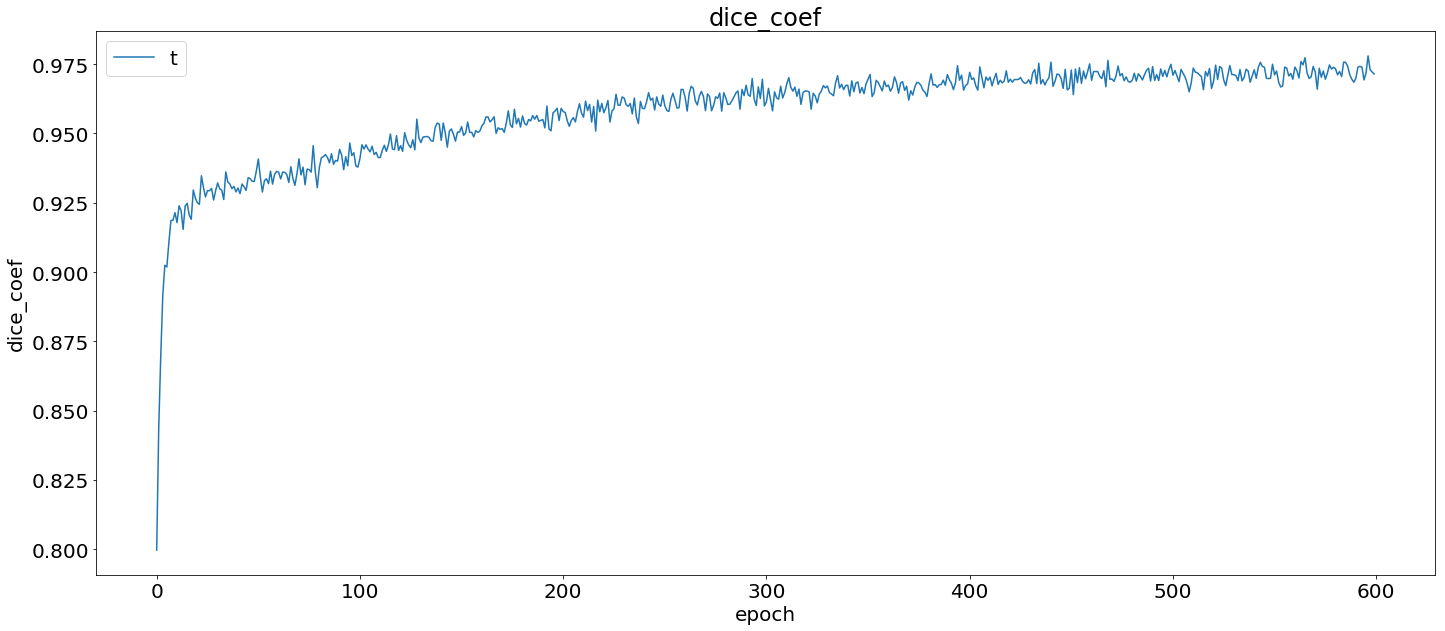

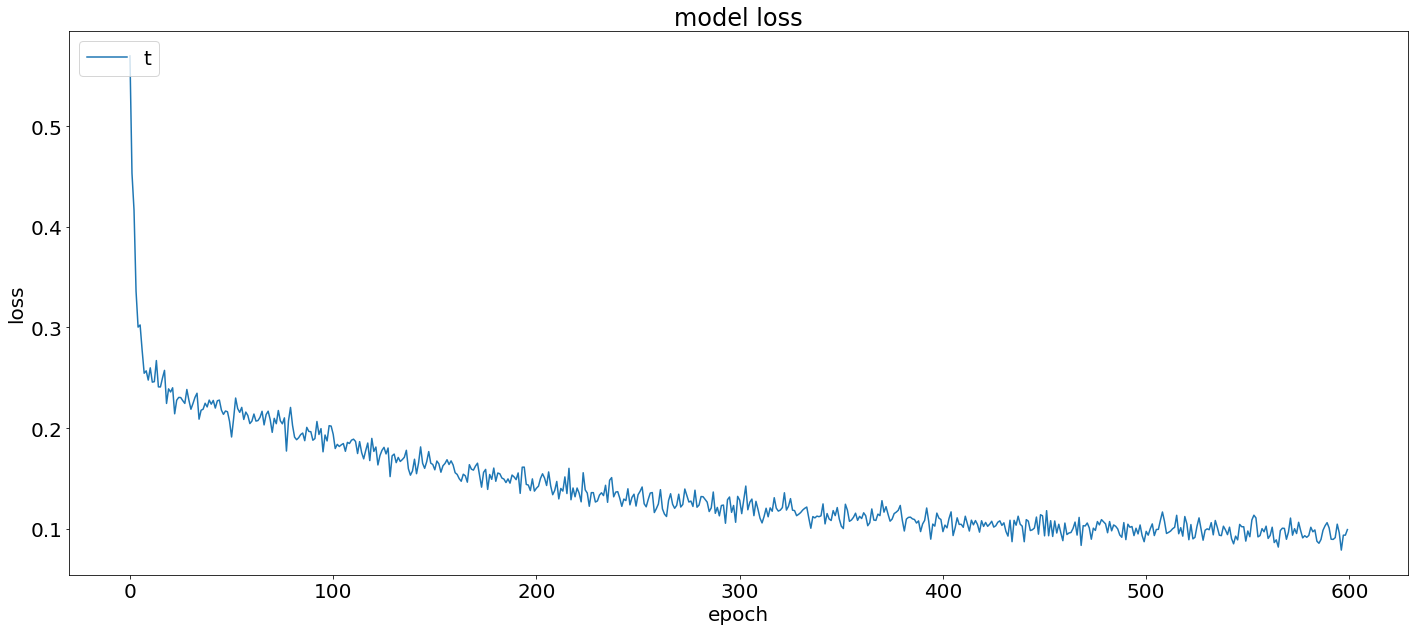

In [31]:
import matplotlib.pylab as pylab

pylab.rcParams['figure.figsize'] = 24, 10 
pylab.rcParams["font.size"] = "20"

# summarize history for accuracy
plt.plot(history.history['dice_coef'])
plt.title('dice_coef')
plt.ylabel('dice_coef')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend('train', loc='upper left')
plt.show()

## How Well Does it Work?

If you remember the poorly masked image above.  Here we can see it compared with the mask created by the Neural Network.



| Original Image | Mask | Masked Image |
| ---- | ---- | ---- |
|![](images/9074c1b18-orig.jpg)|![](images/9074c1b18-mask.jpg)|![](images/9074c1b18-masked_image.jpg)|
|![](images/9074c1b18-orig.jpg)|![](images/9074c1b18-nn-mask.jpg)|![](images/9074c1b18-nn-masked.jpg)|


As you can see, the neural network does a much better job.  If you run all of the images through this neural network you will find that on random inspection it sucessfully masks about 95% of the images.   This is an incredible improvement on just using the thresholding in OpenCV.

## References

   1. https://www.kaggle.com/ecobill/u-nets-with-keras
   2. Olaf Ronneberger, Philipp Fischer, Thomas Brox, U-Net: Convolutional Networks for Biomedical Image Segmentation, MICCAI 2015.  https://arxiv.org/abs/1505.04597
   3. Zijdenbos, A.P.l Dawant, B.M.; Margolin, R.A.; Palmer, A.C. (1994). "Morphometric analysis of white matter lesions in MR images: method and validation". IEEE Transactions on Medical Imaging. Institute of Electrical and Electronics Engineers (IEEE).